# 1. Circulant Matrix Eigenvalues

Every circulant $N \times N$ matrix $A$ is determined by $N$ values $a_k, k\in \mathbb{N}, k < N$ as shown below.

$A = \begin{pmatrix}
a_0 & a_{N-1} & \cdots & a_2 & a_1 \\
a_1 & a_0 & \ddots & \vdots & a_2 \\
\vdots & a_1 & \ddots & a_{N-1} & \vdots \\
a_{N-2} & \vdots & \ddots & a_0 & a_{N-1} \\
a_{N-1} & a_{N-2} & \cdots & a_1 & a_0 
\end{pmatrix} =\sum_{k<N} a_k A_1^k, \text{ with }
A_1 := \begin{pmatrix}
0 & 0 & 0 & \cdots & 0 & 1 \\
1 & 0 & 0 & \cdots & 0 & 0 \\
0 & 1 & 0 & \cdots & 0 & 0 \\
 &  & \ddots & \ddots & \ddots &  \\
0 & 0 & \cdots & 0 & 1 & 0 
\end{pmatrix}$

Because $A$ can be represented as a polynom with the simple circulant matrix $A_1$ as basis, the eigenvectors of $A$ are the eigenvectors of $A_1$ with eigenvalues $\lambda_j(A) = \sum_{k<N} a_k\cdot \lambda_j(A_1)^k$. With the characteristic polynom of $A_1$, $\det(\lambda I - A_1) = \lambda^N - 1$, the eigenvalues of the simple matrix are determined as $\lambda_j(A_1) = \omega^j$ with the $N$-th root of unity $\omega := \exp(\frac{2\pi i}{N})$. The corresponding eigenvectors of $A_1$ are the fourier modes $\vec v_j = \frac{1}{\sqrt{N}} (1, w^j, w^{2j}, \dots, w^{(N-1)j})^T$, therefore the fourier transform $\mathcal{F}_N = (\vec v_0, \vec v_1, \dots, \vec v_{N-1})^T$ diagonalizes $A$ as $A = \mathcal{F}_N^{\dagger} D \mathcal{F}_N$ with the diagonal matrix $D, D_{jj} = \lambda_j(A)$. If the matrix A is also symmetric ($A = A^T$) the eigenvalues are real (for $N$ odd set $a_{N/2}=0$):

$\forall k,  0 < k < \lfloor N/2 \rfloor: a_j = a_{N-j} \Rightarrow \\
\begin{align}
\lambda_j(A) &= a_0 + \sum_{0<k<\lfloor N/2\rfloor} a_k\cdot (\lambda_j(A_1)^k + \lambda_j(A_1)^{N-k}) + a_{N/2}\cdot \lambda_j(A_1)^{N/2}\\ 
&= a_0 + \sum_{0<k<\lfloor N/2\rfloor} a_k\cdot \left(\exp(2\pi i\cdot jk/N) + \exp(-2\pi i\cdot jk/N)\right) + a_{N/2}\cdot \exp(2\pi i\cdot j/2)\\
&= a_0 + \sum_{0<k<\lfloor N/2\rfloor} 2 a_k\cdot \cos(2\pi jk/N) + a_{N/2}\cdot (-1)^j.
\end{align}$

## 1.1 Cosine calculation

To calculate eigenvalues, the cosine for $0\leq x <1, x\in\mathbb{R}$ is approximated with $cos_{aprx}(x) = -1 + 18(x-0.5)^2 - 40 (x-0.5)^4 \approx \cos(2\pi x)$. In order to simplify the calculation and considering the circulant matrix as index transitions over $N = n!$ indices, only the case $A=A^T \land a_0 = a_{N/2} = 0 \land (\forall k, 0<k<\lfloor N/2 \rfloor: a_k \in \{0,1\}) \land |\{k| a_k = 1\}| = \mathcal{Poly(n)} = \mathcal{O}(n^c), c \in \mathbb{N}$ constant, is used. Therefore every eigenvalue is a simple sum of cosines. 

Visual presentation of the cosine approximation $cos_{aprx}(x) = -1 + 16\cdot(x - 0.5)^2 - 32\cdot(x - 0.5)^4$ and $\cos(2\pi x)$ for $0\leq x < 1$. The local minimum and maxima are the same as the cosine.

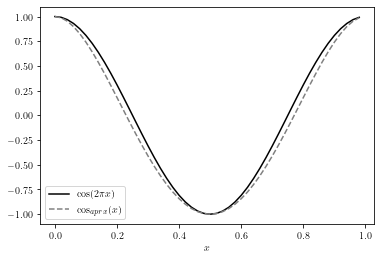

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['text.usetex'] = True

def cos2pi_aprx(x):
    return -1 + 16*(x - 0.5)**2 - 32*(x - 0.5)**4

x = np.linspace(0, 1, endpoint=False)
plt.plot(x, np.cos(2*np.pi*x), c="black", label="$\cos(2\pi x)$")
plt.plot(x, cos2pi_aprx(x), c="gray", ls="--", label="$\cos_{aprx}(x)$")
plt.xlabel("$x$")
plt.legend()
plt.show()

The implementation uses $n$ qubits for the input state $|x\rangle$, where the highest qubit of $x$ is assumed to be representing the value $2^{-1}$, so $x<1$. It creates a rough cosine approximation with $4n-3$ qubits in the signed integer (two's complement) representation. 
The first part of the circuit starts with a case destinction. For the initial state $|0\rangle^n$ we have $\cos(0)=cos_{aprx}(0)=1$. This case is handled later. For the cases $0 < x < 0.5$ (highest qubit is $|0\rangle$, at least one other qubit is $|1\rangle$) the value in the lower qubits $x':=x \text{ mod } 0.5$ gets negated, since $0.5-x \Rightarrow 1 - x'$. This is done by performing $x' \to x'':= \bar x' + 1$ via NOT gates and an incrementer, controlled by the highest qubit.
For the second part of the circuit, this $n-1$ qubit state gets copied with CNOT gates into the first qubits of the empty $cos$ output register. Now the state is multiplied with its own copy via an qiskit $HRSCumulativeMultiplier(n-1, 2n-2)$ [HRSCumulativeMultiplier](https://qiskit.org/documentation/stubs/qiskit.circuit.library.HRSCumulativeMultiplier.html), where the second argument is the number of product qubits. These product qubits now contain $|x''^2\rangle$ and are also stored as ancillas. The copied $|x''\rangle$ state is uncomputed with CNOT gates. This step is repeated one more time with $2 \times (2n-2) \to 4n-4$ qubits to create $|x''^4\rangle$, this time directly in the $cos$ register. The factor $32=2^5$ only results in a shift. Because $\forall 0< x <1: 32\cdot (x-0.5)^4 <2$, the highest qubit representing $2^1$ can be ommited in the multiplication, so $HRSCumulativeMultiplier(2n-2, 4n-5)$ is used. Together with a the omitted qubit and the sign qubit this puts the number of qubits in the $cos$ register at $4n-3$. Now all but the second highest qubit $2^0 = 1$ of the $cos$ register is inverted with NOT gates and incremented, forming $-1-32\cdot(x-0.5)^4$.
The last part of the circuit is adding the $|x''^2\rangle$ state onto the highest qubits of the $cos$ register using $FullAdd(2n-2)$. There is no carry-out required, the highest qubit reaches the sign qubit. In comparison to, the addition is shifted by the factor $2^1$ due to $16\cdot(x-0.5)^2 \leq 4$.
The $cos$ register now contains $|11\rangle \otimes |0\rangle^{4n-5}$ for $x=0$ because the inital state after first part is stil $|0\rangle^{n}$ so all multiplications resulted in $0$ and because of the $cos$ negation. This case is handled with multicontrol NOT gate, controlled by $|x\rangle$ and acting on the sign qubit, resulting in $1$.

The circuit requires $6n-8$ ancillas, $2n-2$ for the storing the first multiplication and $4n-6$ for the incrementer. The ancillas used by the second multiplication, full adder and multi-controlled NOT gate require no additional ancillas. The circuit performs $COS2PI(n) |x\rangle \otimes |0\rangle^{4n-3} \otimes |0\rangle^{6n-8}= |\lfloor 2x \rfloor/2 +x''\rangle \otimes |cos_{aprx}(x)\rangle \otimes |2^4 x''^2\rangle \otimes |0\rangle^{4n-6}$.

The qiskit implementation of the HRSCumulativeMultiplier consists of controlled full adders, resulting in size and depth $\mathcal{O(n^2)}$ for $n$ state qubits. Since the comparator, incrementers and full adder are all $\mathcal{O}(n)$, the circuit has $size(COS2PI(n)) = \mathcal{O}(n^2)$ and $depth(COS2PI(n)) = \mathcal{O}(n^2)$.

In [4]:
from library.functions import Cosine2PI

Cosine2PI(2).decompose().draw(fold=-1)

┌───┐┌─────────┐               ┌───────┐     ┌───┐                                       ┌───┐
  x_0: ─────┤ X ├┤1        ├──■────────────┤0      ├──■──┤ X ├────────────────────────────────────■──┤ X ├
       ┌───┐└─┬─┘│         │  │  ┌───┐┌───┐│       │  │  └───┘                                    │  ├───┤
  x_1: ┤ X ├──■──┤2 Ctrl+1 ├──┼──┤ X ├┤ X ├┤       ├──┼───────────────────────────────────────────■──┤ X ├
       └───┘     │         │┌─┴─┐└───┘└───┘│       │┌─┴─┐     ┌───────┐┌───┐     ┌─────┐          │  └───┘
cos_0: ──────────┤0        ├┤ X ├──────────┤1      ├┤ X ├─────┤4      ├┤ X ├─────┤2    ├──────────┼───────
                 └─────────┘└───┘          │       │└───┘     │       │├───┤     │     │          │       
cos_1: ────────────────────────────────────┤       ├──────────┤5      ├┤ X ├─────┤3    ├──────────┼───────
                                           │       │          │       │├───┤     │     │          │       
cos_2: ────────────────────────────────────┤  Mult ├──────────┤6      ├┤ X ├─────┤4    ├──────────┼───────
                                           │       │          │       │└───┘     │     │┌──────┐  │       
cos_3: ────────────────────────────────────┤       ├──────────┤       ├──────────┤5    ├┤3     ├──┼───────
                                           │       │          │       │┌───┐     │     ││      │┌─┴─┐     
cos_4: ────────────────────────────────────┤4      ├──────────┤7 Mult ├┤ X ├─────┤  +1 ├┤4     ├┤ X ├─────
                                           │       │          │       │└───┘     │     ││      │└───┘     
aux_0: ────────────────────────────────────┤2      ├──■───────┤0      ├──■───────┤     ├┤1     ├──────────
                                           │       │  │       │       │  │       │     ││  Add │          
aux_1: ────────────────────────────────────┤3      ├──┼────■──┤1      ├──┼────■──┤     ├┤2     ├──────────
                                           └───────┘┌─┴─┐  │  │       │┌─┴─┐  │  │     ││      │          
aux_2: ─────────────────────────────────────────────┤ X ├──┼──┤2      ├┤ X ├──┼──┤0    ├┤      ├──────────
                                                    └───┘┌─┴─┐│       │└───┘┌─┴─┐│     ││      │          
aux_3: ──────────────────────────────────────────────────┤ X ├┤3      ├─────┤ X ├┤1    ├┤0     ├──────────
                                                         └───┘└───────┘     └───┘└─────┘└──────┘

Plotting the resulting $cos$ for register shows a good approximation.

0 010000000 1.0
1 001001111 0.6171875
2 111110000 -0.125
3 110011111 -0.7578125
4 110000000 -1.0


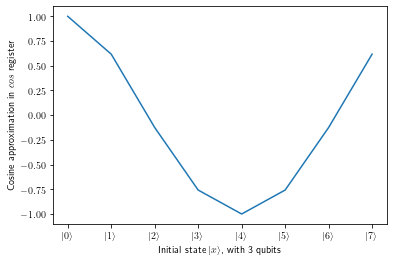

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile

num_state_qubits = 3
shots = 512
cosine = Cosine2PI(num_state_qubits)

initial_states = list(range(2**num_state_qubits))
cosine_results = []

# calculate only half + 1, the results are symmetric
for initial_state in initial_states[:len(initial_states)// 2 + 1]:

    qr_x = QuantumRegister(num_state_qubits, "x")
    qr_cos = QuantumRegister(cosine.num_cosine_qubits, "cos")
    qr_aux = QuantumRegister(cosine.num_ancillas, "aux")
    qc = QuantumCircuit(qr_x, qr_cos, qr_aux)

    for idx, bit in enumerate(reversed(bin(initial_state)[2:])):
        if bit == "1":
            qc.x(idx)
        
    qc.compose(cosine, inplace=True)

    cr = ClassicalRegister(len(qr_cos))
    qc.add_register(cr)
    qc.measure(qr_cos, cr)

    backend_sim = Aer.get_backend('qasm_simulator')
    result_sim = backend_sim.run(transpile(qc, backend_sim), shots=shots).result()
    counts = result_sim.get_counts()
    filtered_counts = {key: counts[key] for key in counts if counts[key] > shots/8}
    if len(filtered_counts) == 1:
        result_string = list(filtered_counts.keys())[0]
        # signed integer
        result = int(result_string[1:], 2)
        result -= 2**(len(result_string) - 1) * int(result_string[0], 2)
        result /= 2**(len(result_string) - 2)
        print(initial_state, result_string, result)
        cosine_results.append(result)
    else:
        print("Multiple results, stopping test")
        break

if len(cosine_results) == len(initial_states)//2 + 1:
    cosine_results = cosine_results + cosine_results[1:-1][::-1]
    
    plt.ylabel("Cosine approximation in $cos$ register")
    plt.ylim(-1.1,1.1)
    plt.xlabel(f"Initial state $|x\\rangle$, with {num_state_qubits} qubits")
    x_ticks = [f"$|{x}\\rangle$" for x in initial_states]
    plt.xticks(initial_states, x_ticks)

    plt.plot(initial_states, cosine_results)
    plt.show()

# 1.2 Calculating the eigenvalues

To calculate the eigenvalues of $A$ with $n_{EVAL}$ qubits precision, the results of $n_K = \lceil log_2 K\rceil, K := |\{k| a_k = 1\}|  = \mathcal{Poly}(n_{EVAL})$ uses of $COS2PI((n_{EVAL} - n_K + 3)/4)$ for pre-calculated $x$ are accumulated. This means that only values $n_{EVAL}: n_{EVAL} - n_K + 3 = 4 \cdot n'_{EVAL}$ with $n'_{EVAL} \in \mathbb{N}, n'_{EVAL} \geq 2$ are allowed. With $\lambda_j(A) = \sum_{0<k<\lfloor N/2\rfloor} 2 a_k\cdot \cos(2\pi jk/N)$, it follows  $x(j) = j\cdot k/N$. Given a list of $k$ values, the implementation uses integer divisions with quotients $Val(k) := \lfloor N/k \rfloor \geq 2$ to approximate $x(j)$. Each divison uses $n'_{EVAL}$ quotient qubits, with which the cosine approximation is calculated. The resulting approximation is added into the evaluation register of size $n_{EVAL}$ and uncomputed (except for the last $k$). The largest reminder register contains $n'_{rmd} := \max_{k \in K} n_{rmd}(k) = \max_{k \in K} \lceil \log_2(Val(k) + 1)\rceil$ qubits. Adding the number of quotient qubits, the required size for the state register is $n'_{rmd} + n'_{EVAL}$. All divisions with less than $n'_{rmd}$ remainder qubits only act on the upper part of the state register. Because the cosine is calculated in the ancilla register, the number of ancillas required for the cosine approximation is qubits is $4n'_{EVAL} - 3 + 6n'_{EVAL} -8$. The maximum ancilla number to contain the maximal negated $ \max_{k \in K} Val(k)$ for the divisions is $n'_{rmd}+1$.
Because the full adders can reuse the uncomputed ancillas of $COS2PI(n'_{EVAL})$, the number of ancillas is $n_{aux} := \max(n'_{rmd}+1, 10n'_{EVAL} - 11)$.
The ciruit performs $SymCircEV(n'_{EVAL}, N, (k| a_k = 1)) |0\rangle^{n'_{rmd} + n'_{EVAL}} \otimes |0\rangle^{n_{EVAL}} \otimes |0\rangle^{n_{aux}} = |0\rangle^{n'_{rmd}} \otimes  |\lfloor 2x \rfloor/2 +x''\rangle \otimes |cos_{aprx}(x)\rangle \otimes |2^4 x''^2\rangle \otimes |0\rangle^{n_{aux} - 2n'_{EVAL}-2}$, using $x, x''$ defined for $COS2PI(n'_{EVAL})$ where $x= \lfloor state /Val(k')\rfloor$ with $k'$ the last element of $(k| a_k = 1)$. 
The divisions have size and depth $\mathcal{O}((n'_{rmd} + n'_{EVAL}) \cdot  n'_{EVAL})$, the adder has size and depth $\mathcal{O}(n_{EVAL}) = \mathcal{O}(n'_{EVAL} + n_K) = \mathcal{O}(n'_{EVAL})$. The cosine approximations have size and depth $\mathcal{O}(n_{EVAL}'^2)$, but dominate the size and depth for low $n'_{rmd}$. With $K$ repetitions, the cirucit has size $size(SymCircEV(n'_{EVAL}, N, (k| a_k = 1)))  = \mathcal{O}(K \cdot (n'_{rmd} + n'_{EVAL}) \cdot  n'_{EVAL})$ and depth $depth(SymCircEV(n'_{EVAL}, N, (k| a_k = 1)))  = \mathcal{O}(K \cdot (n'_{rmd} + n'_{EVAL}) \cdot  n'_{EVAL})$.

In [3]:
from library.functions import SymCircEigenVal

SymCircEigenVal(2, 11, [3, 2]).decompose().draw(fold=-1)

┌─────────────┐                            
state_0: ───────────────────────────────────────────────────────────────────────────────┤4            ├────────────────────────────
         ┌─────────────┐                                              ┌────────────────┐│             │                            
state_1: ┤3            ├──────────────────────────────────────────────┤3               ├┤5            ├────────────────────────────
         │             │                                              │                ││             │                            
state_2: ┤4            ├──────────────────────────────────────────────┤4               ├┤6            ├────────────────────────────
         │             │┌─────────────┐             ┌────────────────┐│                ││             │┌─────────────┐             
state_3: ┤5            ├┤0            ├─────────────┤0               ├┤5               ├┤7            ├┤0            ├─────────────
         │             ││             │             │                ││                ││             ││             │             
state_4: ┤6            ├┤1            ├─────────────┤1               ├┤6               ├┤8            ├┤1            ├─────────────
         │             ││             │┌───────────┐│                ││                ││             ││             │┌───────────┐
 eval_0: ┤             ├┤             ├┤6          ├┤                ├┤                ├┤             ├┤             ├┤6          ├
         │             ││             ││           ││                ││                ││             ││             ││           │
 eval_1: ┤             ├┤             ├┤7          ├┤                ├┤                ├┤             ├┤             ├┤7          ├
         │             ││             ││           ││                ││                ││             ││             ││           │
 eval_2: ┤  Div(3//11) ├┤             ├┤8          ├┤                ├┤  Div(3//11)_dg ├┤  Div(2//11) ├┤             ├┤8          ├
         │             ││             ││           ││                ││                ││             ││             ││           │
 eval_3: ┤             ├┤             ├┤9          ├┤                ├┤                ├┤             ├┤             ├┤9          ├
         │             ││             ││           ││                ││                ││             ││             ││           │
 eval_4: ┤             ├┤             ├┤10         ├┤                ├┤                ├┤             ├┤             ├┤10         ├
         │             ││             ││           ││                ││                ││             ││             ││           │
 eval_5: ┤             ├┤             ├┤           ├┤                ├┤                ├┤             ├┤             ├┤11         ├
         │             ││             ││           ││                ││                ││             ││             ││           │
  aux_0: ┤0            ├┤2  COS(2PIx) ├┤1          ├┤2  COS(2PIx)_dg ├┤0               ├┤0            ├┤2  COS(2PIx) ├┤1          ├
         │             ││             ││           ││                ││                ││             ││             ││           │
  aux_1: ┤1            ├┤3            ├┤2  FullAdd ├┤3               ├┤1               ├┤1            ├┤3            ├┤2  FullAdd ├
         │             ││             ││           ││                ││                ││             ││             ││           │
  aux_2: ┤2            ├┤4            ├┤3          ├┤4               ├┤2               ├┤2            ├┤4            ├┤3          ├
         └─────────────┘│             ││           ││                │└────────────────┘│             ││             ││           │
  aux_3: ───────────────┤5            ├┤4          ├┤5               ├──────────────────┤3            ├┤5            ├┤4          ├
                        │             ││           ││                │                  └─────────────┘│             ││         